## Алгоритмы машинного обучения. Деревья решений. Случайный лес

In [147]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import export_graphviz
import graphviz
np.random.seed(20)

Для сходимости ответов у вас должен быть установлен sklearn версии 0.21.3

In [2]:
print(sklearn.__version__)

0.21.3


In [148]:
data = pd.read_csv('titanic_train.csv')

In [149]:
data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data['age'] = np.trunc(data['age'])
data = data.fillna(data.median())

## Поиск порога для разбиения по числовому признаку в деревьях решений.

На практическом занятии мы вручную разбивали исходную выборку по признаку "пол" и смотрели на значение функционала качества при таком разбиении, а также на значения энтропии в двух получившихся после разбиения выборках. Признак "пол" был бинарным, поэтому у нас имелся только один возможный порог для разбиения. В случае с числовыми признаками все иначе.
Если признак числового типа, то в узле формируется правило вида $X_i <= t$. Где $t$ – некоторый порог, который чаще всего выбирается как среднее арифметическое двух соседних упорядоченных значений признака $X_i$ обучающей выборки.
Мы будем работать с признаков "возраст". Найдите с точки зрения функционала качества оптимальный порог для разбиения по этому признаку. Для этого необходимо:
- найти уникальные значения признака "возраст" в исходной выборке, упорядочить их по возрастанию;
- рассчитать средние значения между двумя сосденими элементами получившегося упорядоченного ряда (пример: для ряда [18, 19, 20, 21] результат будет [18.5, 19.5, 20.5]). Они будут являться множеством порогов для поиска;
- среди полученного множества найти тот порог, при котором достигается максимум функции $Q(X, j, t)$, где $X$ – исходная выборка, $j$ – признак ("age"), $t$ - порог, который требуется найти.

Для справки:
$$Q(X, j, t) = H(X) - \dfrac{|X_l|}{|X|} H(X_l) - \dfrac{|X_r|}{|X|} H(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $H(X)$ – энтропия ответов на выборке $X$:
$$H(X) = - \sum_{k=0}^{N}(p_k ln p_k),$$
где $k$ – номер класса, $p_k$ – доля объектов класса $k$ в выборке $X$.

Вы можете использовать функции, которые были реализованы в начале практики.

In [150]:
# реализуем функцию для расчета функционала качества

def Q(X, j, t):
    Xl = X[X[j] <= t]
    Xr = X[X[j] > t]
    quality = H(X) - len(Xl)/len(X)*H(Xl) - len(Xr)/len(X)*H(Xr)
    return quality

# реализуем функцию для расчета энтропии ответов

def H(X):
    if X['survived'].nunique() != 2:
        return 0
    else: 
        p1 = len(X[X['survived'] == 0]) / len(X)
        p2 = len(X[X['survived'] == 1]) / len(X)
        ent = - (p1*np.log(p1) + p2*np.log(p2))
    return ent

def opt_threshold(X, j):
    uniques_in_feature = np.sort(data[j].unique())
    mean_thresholds = np.vstack((uniques_in_feature[1:], 
                                 uniques_in_feature[:-1])) \
    .mean(axis=0)
    Q_on_means = []
    for threshold in mean_thresholds:
        Q_on_means.append(Q(data, j, threshold))

    opt_threshold = max(zip(mean_thresholds, Q_on_means), 
           key=lambda x: x[1])
    print("Threshold_{} = {}".format(j, np.round(opt_threshold[0], 3)))
    print("Q_{}= {}".format(j, np.round(opt_threshold[1], 3)))
    
opt_threshold(data, 'age')
opt_threshold(data, 'sex')

Threshold_age = 9.5
Q_age= 0.01
Threshold_sex = 0.5
Q_sex= 0.132


Оптимальное значение порога разбиения по признаку "возраст" по функционалу качества threshold_age = 9.5.
Значение функционала качества Q при разбиении по признаку "возраст" с полученным порогом 0.01. Такое разбиение более оптимальное по сравнению с разбиением по признаку "пол"

## Деревья решений

В этом задании мы будем работать с датасетом Сalifornia housing. Решать предстоит задачу регресси: прогнозирование цены недвижимости (признак Price).
Для оценки качества модели мы будем использовать коэффициент детерминации r2. Для подбора гиперпараметров моделей будем использовать обычную пятифолдовую кросс-валидацию.

In [169]:
data = pd.read_csv('California_housing.csv')
X = data.drop('Price', axis = 1)
y = data['Price']

Разделите выборку на обучающую и тестовую в соотношении 7:3. Зафиксируйте `random_state`=20. Так как решаем задачу регрессии, нам не нужно использовать параметр `stratify`.

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

Обучите дерево решений на обучающей выборке с параметрами по умолчанию (лишь зафиксируйте `random_state`=20) и оцените скор на тестовой. В качестве метрики в этом домашнем задании используйте коэффициент детерминации (функция r2_score из sklearn).

In [171]:
tree = DecisionTreeRegressor(random_state=20)
tree.fit(X_train, y_train)
preds_test = tree.predict(X_test)
r2_tree = r2_score(y_test, preds_test)
print('r2_score = ', np.round(r2_tree, 3))

r2_score =  0.638


Осуществите с помощью GridSearchCV поиск оптимального значения максимальной глубины в дереве. В качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5 (обычная пятифолдовая кросс-валидация). Для поиска оптимального значения максимальной глубины используйте значения от 1 до 20. Выведите получившиеся оптимальное значение гиперпараметра. Сохраните модель с получившимся значением гиперпараметра и оцените скор на тестовой выборке. 

In [172]:
tree = DecisionTreeRegressor(random_state=20)
param_grid = {'max_depth': np.arange(1, 21)}
grid_searchcv = GridSearchCV(tree, param_grid=param_grid, 
                             scoring='r2', cv=5)
grid_searchcv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=20, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [173]:
grid_searchcv.best_params_

{'max_depth': 9}

In [174]:
grid_estimator = grid_searchcv.best_estimator_
preds_test = grid_estimator.predict(X_test)
r2_grid = r2_score(y_test, preds_test)
print('r2_score = ', r2_score(y_test, preds_test))

r2_score =  0.7071114029124781


На сколько улучшился скор на тесте после подбора максимальной глубины дерева на кросс-валидации

In [175]:
np.round(abs(r2_grid - r2_tree), 3)

0.069

Визуализация построенного дерева с лучшим гиперпараметром. Признак MedInc оказался самым важным, то есть поместился в вершину построенного дерева решений

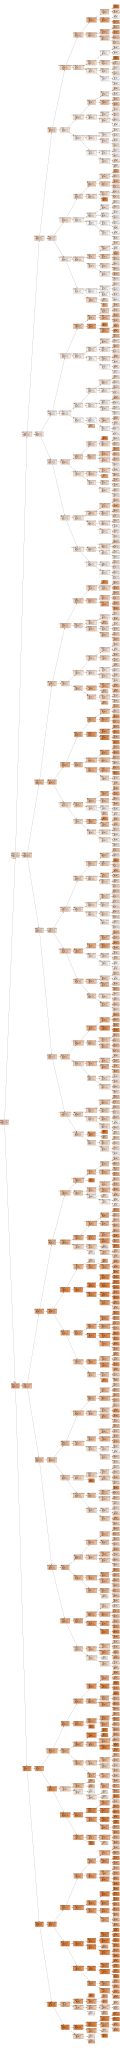

In [176]:
viz_best_grid = export_graphviz(grid_estimator, 
                                feature_names=X_train.columns, 
                                filled=True,
                                rotate=True)
graphviz.Source(viz_best_grid)


Постройте графики зависимости коэффициента детерминации на трейне и кросс-валидации от значения максимальной глубины (кривые валидации). Используйте заданные ранее значения для данного гиперпараметра (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

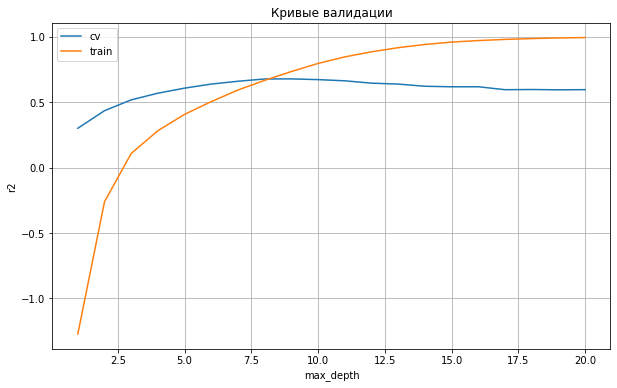

In [178]:
train_scores = []
cv_scores = []
max_depth_values = np.arange(1, 21)
for max_depth in max_depth_values:
    model = DecisionTreeRegressor(max_depth = max_depth, 
                                  random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, 
                               cv = 5, scoring = 'r2').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = r2_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, label = 'cv')
plt.plot(max_depth_values, train_scores, label = 'train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.legend()
plt.show()

На кривых валидации видно, что после max_depth = 10 наблюдается недообучение. 

## Случайный лес

Обучите случайный лес на обучающей выборке с параметрами по умолчанию (лишь зафиксируйте `random_state`=20) и оцените скор на тестовой. В качестве меткрики используйте коэффициент детерминации (функция r2_score).

In [179]:
rf = RandomForestRegressor(random_state = 20)
rf.fit(X_train, y_train)
preds_test = rf.predict(X_test)
r2_rf = r2_score(y_test, preds_test)
print('r2_score = ', r2_rf)

r2_score =  0.8118845584612047


Осуществите с помощью GridSearchCV поиск оптимальных значений максимальной глубины (диапазон для поиска: от 1 до 17 с шагом 2) и минимального числа объектов в листе (диапазон для поиска: от 1 до 21 с шагом 4). В качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5 (обычная пятифолдовая кросс-валидация). Выведите данные оптимальные значения. Сохраните модель с получившимся значениями гиперпараметров и оцените скор на тестовой выборке. 

In [180]:
rf = RandomForestRegressor(random_state = 20)
param_grid = {'max_depth': np.arange(1, 18, 2), 
              'min_samples_leaf': np.arange(1, 22, 4)}
grid_searchcv = GridSearchCV(rf, param_grid=param_grid, 
                             scoring='r2', cv=5)
grid_searchcv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=20,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [181]:
grid_searchcv.best_params_

{'max_depth': 17, 'min_samples_leaf': 1}

In [184]:
grid_estimator = grid_searchcv.best_estimator_
preds_test = grid_estimator.predict(X_test)
r2_grid = r2_score(y_test, preds_test)
print('r2_score = ', np.round(r2_score(y_test, preds_test), 3))

r2_score =  0.811


На сколько улучшился скор на тесте после подбора гиперпараметров случайного леса на кросс-валидации

In [185]:
np.round(abs(r2_grid - r2_rf), 3)

0.001

Оцените важности признаков для случайного леса с лучшим значениями гиперпараметров. Расположите признаки в порядке убывания их важности

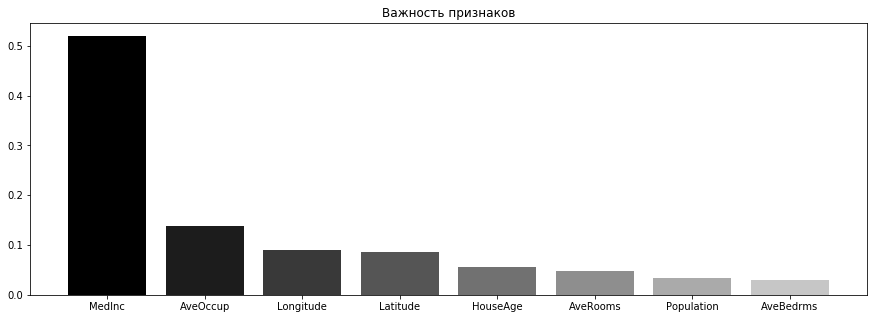

In [189]:
importances = grid_estimator.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,5))
plt.title("Важность признаков")
bars = plt.bar(X_train.columns[indices], 
               importances[indices],
       color=([str(i/float(len(indices)+1)) 
               for i in range(len(indices))]),
               align="center")


Постройте кривые валидации при подборе максимальной глубины (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). Используйте заданные ранее значения для данного гиперпараметра. В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

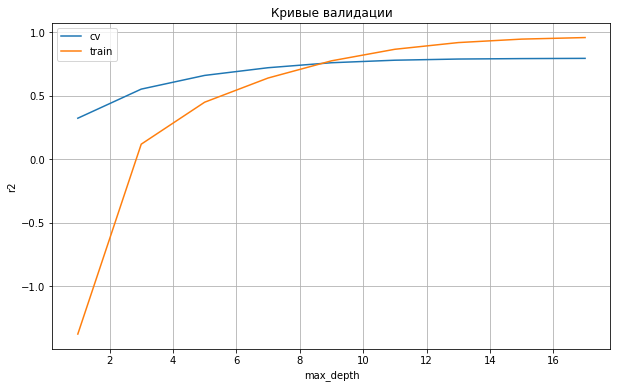

In [187]:
train_scores = []
cv_scores = []
max_depth_values = np.arange(1, 18, 2)
for max_depth in max_depth_values:
    model = RandomForestRegressor(max_depth = max_depth, 
                                  random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, 
                               cv = 5, scoring = 'r2').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = r2_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, label = 'cv')
plt.plot(max_depth_values, train_scores, label = 'train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.legend()
plt.show()

Уменьшив максимальную глубину со значения 17 можно добиться
- небольшого прироста скора на кросс-валидации
- снижения разности скоров на тренировочной выборке и кросс-валидации при сохранении неплохого скора (> 0.70) на кросс-валидации

Постройте кривые валидации при подборе минимального числа объектов в листе (остальные гиперпараметры оставьте по умолчанию, зафиксировав лишь `random_state` = 20). Используйте заданные ранее значения для данного гиперпараметра. В функции cross_val_score так же в качестве параметра `scoring` укажите 'r2', а в качестве параметра `cv` укажите 5.

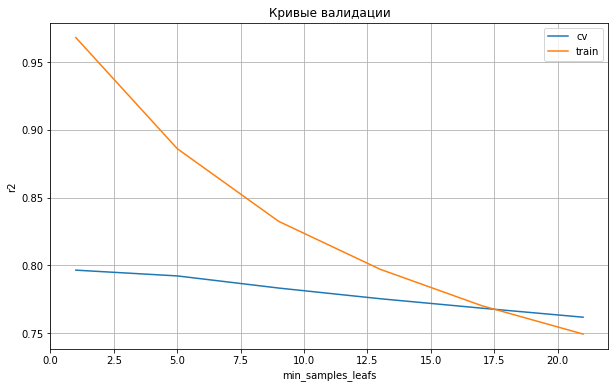

In [188]:
train_scores = []
cv_scores = []
min_samples_leafs = np.arange(1, 22, 4)
for msl in min_samples_leafs:
    model = RandomForestRegressor(min_samples_leaf = msl, 
                                  random_state=20)
    cv_score = cross_val_score(model, X_train, y_train, 
                               cv = 5, scoring = 'r2').mean()
    cv_scores.append(cv_score)
    model.fit(X_train, y_train)
    preds_train = model.predict(X_train)
    train_score = r2_score(preds_train, y_train)
    train_scores.append(train_score)
    
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leafs, cv_scores, label = 'cv')
plt.plot(min_samples_leafs, train_scores, label = 'train')
plt.title('Кривые валидации')
plt.grid()
plt.xlabel('min_samples_leafs')
plt.ylabel('r2')
plt.legend()
plt.show()